In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import ast
from sklearn.model_selection import train_test_split

# Load dataset
df = pd.read_csv("final_combined_mutation_dataset.csv")

# Select relevant columns
df = df[['Encoded_Sequence','Geo_Location','Tissue_Specimen_Source','Collection_Year','Body_Temperature','Parasite_Density','Mutation_Label']]

# Parse stringified lists into actual lists
df['Encoded_Sequence'] = df['Encoded_Sequence'].apply(ast.literal_eval)

# Drop missing rows
df = df.dropna()

# Train-test split
df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)
features = ['Collection_Year', 'Body_Temperature', 'Parasite_Density']


In [3]:
def normalize(df, features, min_val=None, max_val=None):
    if min_val is None:
        min_val = df[features].min()
    if max_val is None:
        max_val = df[features].max()
    df_norm = df.copy()
    df_norm[features] = (df[features] - min_val) / (max_val - min_val + 0.0001)
    return df_norm, min_val, max_val

In [4]:
# ✅ Normalize train and test on same scale
df_train, min_train, max_train = normalize(df_train, features)
df_test, _, _ = normalize(df_test, features, min_val=min_train, max_val=max_train)

In [5]:
from QLSTM import SequenceDataset
from torch.utils.data import DataLoader

sequence_length = 3
batch_size = 1
target = 'Mutation_Label'  # ✅ Add this line to fix the error

train_dataset = SequenceDataset(df_train, target=target, features=features, sequence_length=sequence_length)
test_dataset = SequenceDataset(df_test, target=target, features=features, sequence_length=sequence_length)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Check
X, y = next(iter(train_loader))
print("✅ Features shape:", X.shape)
print("🎯 Target shape:", y.shape)


✅ Features shape: torch.Size([1, 3, 3])
🎯 Target shape: torch.Size([1])


In [6]:
def train_model(data_loader, model, loss_function, optimizer):
    num_batches = len(data_loader)
    total_loss = 0
    model.train()
    
    for X, y in data_loader:
        output = model(X)
        loss = loss_function(output, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    avg_loss = total_loss / num_batches
    print(f"Train loss: {avg_loss}")
    return avg_loss


def test_model(data_loader, model, loss_function): 
    num_batches = len(data_loader)
    total_loss = 0

    model.eval()
    with torch.no_grad():
        for X, y in data_loader:
            output = model(X)
            total_loss += loss_function(output, y).item()

    avg_loss = total_loss / num_batches
    print(f"Test loss: {avg_loss}")
    return avg_loss

def predict(data_loader, model):
    """Just like `test_loop` function but keep track of the outputs instead of the loss
    function.
    """
    output = torch.tensor([])
    model.eval()
    with torch.no_grad():
        for X, _ in data_loader:
            y_star = model(X)
            output = torch.cat((output, y_star), 0)
    
    return output

In [7]:
import torch
import torch.nn as nn
from QLSTM import ShallowRegressionLSTM

learning_rate = 0.01
num_hidden_units = 7
# When defining the model
model = ShallowRegressionLSTM(num_sensors=3, hidden_units=64)


X_test_tensor = torch.tensor(df_test['Encoded_Sequence'].tolist(), dtype=torch.float32)
X_test_tensor = X_test_tensor.unsqueeze(-1)  # Make shape (batch, seq_len, 1)

model = ShallowRegressionLSTM(
    num_sensors=len(features),
    hidden_units=num_hidden_units,
    num_layers=1
)
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


In [8]:
for X_batch, y_batch in train_loader:
    print("Input shape:", X_batch.shape)  # should be (batch_size, seq_len, num_features)
    break


Input shape: torch.Size([1, 3, 3])


In [9]:
# Count number of parameters
num_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Number of parameters: {num_params}")

Number of parameters: 344


In [10]:
classical_loss_train = []
classical_loss_test = []
print("Untrained test\n--------")
# test_loss = test_model(test_loader, model, loss_function)
print()

num_epochs = 150

for ix_epoch in range(num_epochs):
    print(f"Epoch {ix_epoch}\n---------")
    train_loss = train_model(train_loader, model, loss_function, optimizer=optimizer)
    test_loss = test_model(test_loader, model, loss_function)
    classical_loss_train.append(train_loss)
    classical_loss_test.append(test_loss)
   


Untrained test
--------

Epoch 0
---------
Train loss: 0.2572755619873442
Test loss: 0.250047323256731
Epoch 1
---------
Train loss: 0.25097094248980284
Test loss: 0.2629862140864134
Epoch 2
---------
Train loss: 0.252906530238688
Test loss: 0.24980871610343455
Epoch 3
---------
Train loss: 0.25178427414968607
Test loss: 0.26300408206880094
Epoch 4
---------
Train loss: 0.25189440743997693
Test loss: 0.2721877250820398
Epoch 5
---------
Train loss: 0.2539498652331531
Test loss: 0.25199422404170035
Epoch 6
---------
Train loss: 0.2512934324145317
Test loss: 0.25229025453329085
Epoch 7
---------
Train loss: 0.2517047746665776
Test loss: 0.25834667183458804
Epoch 8
---------
Train loss: 0.25228367941454055
Test loss: 0.25454366065561773
Epoch 9
---------
Train loss: 0.25289744783192875
Test loss: 0.2534703331440687
Epoch 10
---------
Train loss: 0.253050301996991
Test loss: 0.2499554808437824
Epoch 11
---------
Train loss: 0.2501848381292075
Test loss: 0.25507475916296246
Epoch 12
-------

In [11]:
train_eval_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
test_eval_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

ystar_col_Q = "Model Forecast"
df_train[ystar_col_Q] = predict(train_eval_loader, model).numpy()
df_test[ystar_col_Q] = predict(test_eval_loader, model).numpy()

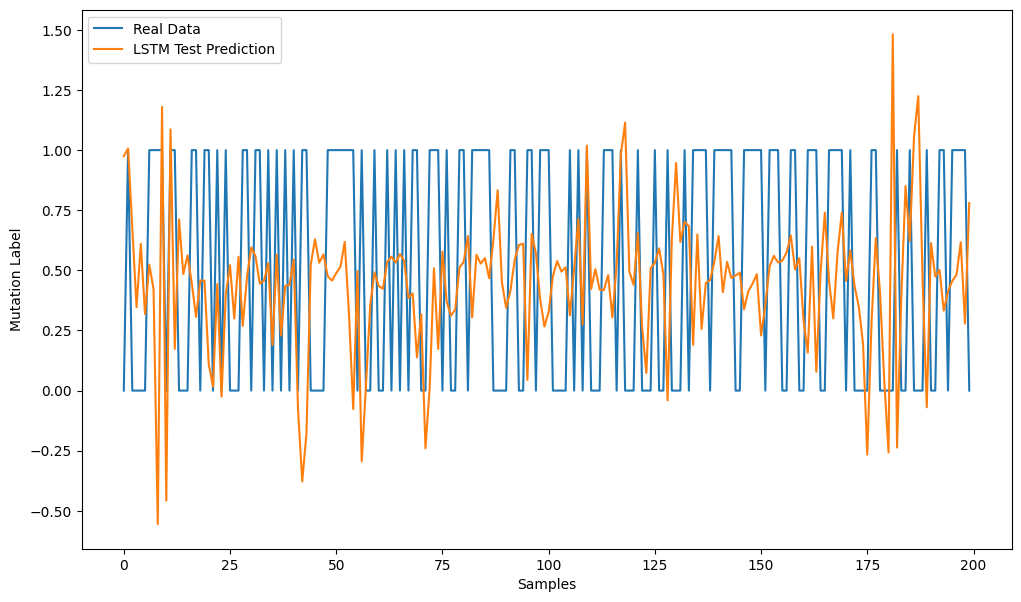

In [12]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 7))
plt.plot(range(len(df_test)), df_test['Mutation_Label'], label="Real Data")
plt.plot(range(len(df_test)), df_test["Model Forecast"], label="LSTM Test Prediction")
plt.ylabel('Mutation Label')
plt.xlabel('Samples')
plt.legend()
plt.show()


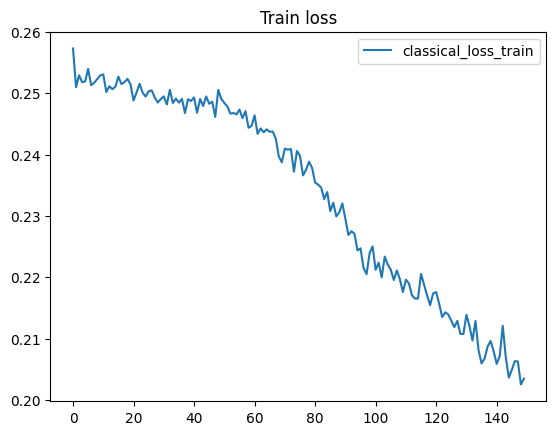

In [13]:
plt.plot(classical_loss_train, label='classical_loss_train')
# plt.plot(classical_loss_test, label='classical_loss_test')
pd.DataFrame(classical_loss_train).to_csv('LSTM_loss.csv', index=False)
plt.title('Train loss')
plt.legend()

In [14]:
import math
from sklearn.metrics import mean_squared_error

# Calculate RMSE between actual and predicted mutation values
train_rmse = math.sqrt(mean_squared_error(df_train["Mutation_Label"], df_train["Model Forecast"]))
test_rmse = math.sqrt(mean_squared_error(df_test["Mutation_Label"], df_test["Model Forecast"]))

print(f"Train RMSE: {train_rmse}")
print(f"Test RMSE: {test_rmse}")


Train RMSE: 0.44257492037334284
Test RMSE: 0.5990401557651597


In [15]:
import numpy as np  # ✅ Make sure this is included

# Calculate the accuracy of the model (tolerance = 0.1)
def accuracy(y, y_star):
    return np.mean(np.abs(y - y_star) < 0.1)

train_accuracy = accuracy(df_train["Mutation_Label"], df_train["Model Forecast"])
test_accuracy = accuracy(df_test["Mutation_Label"], df_test["Model Forecast"])

print(f"Train accuracy: {train_accuracy:.4f}")
print(f"Test accuracy: {test_accuracy:.4f}")


Train accuracy: 0.0963
Test accuracy: 0.0500


In [20]:
import torch

features = ["Encoded_Sequence", "Geo_Location", "Body_Temperature"]  # example: adjust as needed
feature_tensors = []

sequence_length = len(df_test.iloc[0]["Encoded_Sequence"])
batch_size = len(df_test)

for feature in features:
    if feature == "Encoded_Sequence":
        tensor = torch.tensor(df_test[feature].tolist(), dtype=torch.float32)  # shape: (batch, seq_len)
    else:
        # Scalar feature: (batch, 1) → repeat along sequence_length to match (batch, seq_len)
        scalar_vals = df_test[feature].values.reshape(-1, 1)
        tensor = torch.tensor(scalar_vals, dtype=torch.float32).repeat(1, sequence_length)
    
    feature_tensors.append(tensor.unsqueeze(-1))  # shape: (batch, seq_len, 1)

# Concatenate along last dimension: final shape (batch, seq_len, num_features)
X_test_tensor = torch.cat(feature_tensors, dim=2)

# Target tensor
y_test_tensor = torch.tensor(df_test["Mutation_Label"].values, dtype=torch.float32)


In [29]:
print("X_test_tensor shape:", X_test_tensor.shape)
print("Model expected input size:", model.lstm.input_size)


X_test_tensor shape: torch.Size([200, 100, 1])
Model expected input size: 3


In [40]:
import torch

model.eval()
prediction_scores = []

sequence_length = len(df_test.iloc[0]["Encoded_Sequence"])

with torch.no_grad():
    for i in range(len(df_test)):
        seq = torch.tensor(df_test.iloc[i]["Encoded_Sequence"], dtype=torch.float32).view(1, sequence_length, 1)
        temp = torch.tensor([df_test.iloc[i]["Body_Temperature"]], dtype=torch.float32).repeat(sequence_length).view(1, sequence_length, 1)
        geo = torch.tensor([df_test.iloc[i]["Geo_Location"]], dtype=torch.float32).repeat(sequence_length).view(1, sequence_length, 1)

        x_input = torch.cat([seq, geo, temp], dim=2)  # Shape: (1, seq_len, 3)

        prediction = model(x_input).item()
        prediction_scores.append(prediction * 100)  # Convert to percentage

# Prepare final dataframe
output_df = pd.DataFrame({
    "Data_No": range(len(df_test)),
    "Mutation_Label": df_test["Mutation_Label"].values,
    "Predicted_Percentage": prediction_scores
})

output_df.to_csv("mutation_prediction_summary.csv", index=False)
print("✅ Saved mutation prediction summary to mutation_prediction_summary.csv")


✅ Saved mutation prediction summary to mutation_prediction_summary.csv


In [31]:
print("X_test_tensor shape:", X_test_tensor.shape)
print("Model expected input_size:", model.lstm.input_size)


X_test_tensor shape: torch.Size([200, 100, 1])
Model expected input_size: 3
